# Import Libraries

In [25]:
import pandas as pd #for reading csv file and data manipulation
import numpy as np #for array operation
import matplotlib.pyplot as plt #for plotting graphs

# Import Data 

In [26]:
df = pd.read_csv('meteo1.csv',header=None) #read and save csv file
df = df[0].str.split(' ',expand=True).astype('int') #convert string to integer also convert sequence to 100 columns
v  = df.values[:,:] #convert to array
v

array([[1, 2, 2, ..., 0, 0, 2],
       [1, 2, 1, ..., 1, 2, 1],
       [1, 2, 1, ..., 2, 1, 2],
       ...,
       [2, 0, 1, ..., 1, 2, 0],
       [0, 2, 0, ..., 0, 2, 2],
       [0, 1, 1, ..., 0, 1, 1]])

# All Functions Below

In [27]:
# function to define and intialise parameters

def init_params(V,H, uniform = False):
    if uniform:
        ph = np.ones((H, 1))
    else:
        ph = np.random.random((H, 1))
    ph = ph/ph.sum(axis=0)

    if uniform:
        pv1gh = np.ones((V, H))
    else:
        pv1gh = np.random.random((V, H))
    pv1gh = pv1gh/pv1gh.sum(axis=0)
    
    if uniform:
        pvgvh = np.ones((V,V, H))
    else:
        pvgvh = np.random.random((V,V, H))
    pvgvh = pvgvh/pvgvh.sum(axis=0)
    return ph , pv1gh , pvgvh

In [28]:
def logsumexp(a, *args):
   
   
   
    
    if len(args) == 0:
        b = np.ones_like(a)
    else:
        b = args[0]
        if np.isscalar(b):
            b = b * np.ones_like(a)

    amax = np.max(a)
    A = a.shape[0] if len(a.shape) > 1 else 1
    anew = amax + np.log(np.sum(np.exp(a - np.tile(amax, (A, 1))) * b, axis=0))

    return anew

def condexp(logp):
    # CONDEXP: Compute p \propto exp(logp)
    pmax = np.max(logp, axis=0)
    P = logp.shape[0] if len(logp.shape) > 1 else 1
    pnew = condp(np.exp(logp - np.tile(pmax, (P, 1))))
    
    return pnew




def condp(pin, distvars=None):

# Generate a conditional distribution matrix, pnew, based on the positive matrix pin.
# Ensure that the sum of probabilities across specified distribution indices is equal to 1.
# The optional argument allows customization of the indices representing distribution variables.




    m = np.max(pin)
    if m > 0:
        p = pin / m
    else:
        p = pin + np.finfo(float).eps  # in case all unnormalized probabilities are zero

    if distvars is None:
     
        pnew = p / np.sum(p, 0)
    else:
        allvars = np.arange(pin.ndim)
        sizevars = pin.shape
        condvars = np.setdiff1d(allvars, distvars)
        newp = np.transpose(pin, distvars + condvars)
        newp = np.reshape(newp, (np.prod(sizevars[distvars]), np.prod(sizevars[condvars])))
        newp = newp / np.tile(np.sum(newp, 0), (newp.shape[0], 1))
        pnew = np.reshape(newp, sizevars[distvars + condvars])
        pnew = np.transpose(pnew, distvars + condvars)

    return pnew




In [29]:
def fit_mixture_of_markov_chains(uniform=False):
    V=3
    H=3
    pi,A,B = init_params(V,H,uniform=uniform) #intial parameters
    
    pi_old=[]
    ll=[]
    loglik_iter = []
    eps = 1e-20 #epsilon takes care of underflow

    for i in range(30):
        # E step Starts here
        pi_stat = np.zeros((H,1))
        A_stat =np.zeros((V,H));
        B_stat =np.zeros((V,V,H));
        loglik=0
        pi_old=[]
        for n in range(v.shape[0]): #iterate through every observation
            
            lpi_old = np.log(A[[v[n][0]],:].T+eps)+np.log(pi) #for the first oobservation there is no past data 
            
            for t in range(1,v.shape[1]): #iterate through all times from 1 till end
                
                lpi_old = lpi_old +(np.log(B[v[n][[t]], v[n][[t-1]], :])).reshape(-1,1) #log addition 
                    
            pi_old.append(condexp(lpi_old)) #append to pi_old by exponentiating
            
            loglik = loglik + logsumexp(lpi_old,np.ones((H,1))).flatten().sum() #calculate log liklihood
            
           
            pi_stat = pi_stat + pi_old[n]
            A_stat[v[n][[0]],:] = A_stat[v[n][[0]],:]+ pi_old[n].T
            
           
            for t in range(1,v.shape[1]):
                B_stat[v[n][t], v[n][t-1], :] = B_stat[v[n][t], v[n][t-1], :]  + np.squeeze(pi_old[n])
    
              
    	# M step	
        pi = condp(pi_stat)
        A = condp(A_stat)
        B = condp(B_stat)
        loglik_iter.append(loglik)
    return loglik_iter, pi, A, B


In [30]:
def loglik_out(data,A,pi,B):
    pi_old=[]
    H=3
    ll = []
    obs =[]
    for n in range(data.shape[0]):
        lpi_old = np.log(A[[data[n][0]],:].T)+np.log(pi)
          
        for t in range(1,data.shape[1]):
            lpi_old = lpi_old +(np.log(B[data[n][[t]], data[n][[t-1]], :])).reshape(-1,1)
    
        loglik = logsumexp(lpi_old,np.ones((A.shape[0],1))).flatten().sum()
        ll.append(loglik)
        obs.append(n+1)
    return pd.DataFrame(list(zip(obs,ll)),
               columns =['Observation Number', 'Log Likelihood'])

In [31]:
def log_posterior(data,A,pi,B):
    pi_old=[]
    H=3
    ll = []
    obs =[]
    my_res = []
    my_res_log = []
    vals =[]
    all_lpi_old = []
 
    for n in range(data.shape[0]):
        lpi_old = np.log(A[[data[n][0]],:].T )+np.log(pi)
            
        for t in range(1,data.shape[1]):

            lpi_old = lpi_old +(np.log(B[data[n][[t]], data[n][[t-1]], :])).reshape(-1,1)
        all_lpi_old.append(lpi_old)
        my_res_log.append(condexp(lpi_old))
        my_res.append(np.log(condexp(lpi_old)))
        vals.append(np.argmax(lpi_old))
    return my_res , my_res_log, vals, all_lpi_old

# All Outputs below

In [32]:
all_loglik_iter, all_pi, all_A, all_B = [], [], [], []
for _ in range(10):
    loglik_iter, pi, A, B = fit_mixture_of_markov_chains()
    all_loglik_iter.append(loglik_iter)
    all_pi.append(pi)
    all_A.append(A)
    all_B.append(B)

In [33]:
which_idx = -5
print(all_pi[which_idx])
pi, A, B = all_pi[which_idx], all_A[which_idx], all_B[which_idx]

[[0.29969894]
 [0.192     ]
 [0.50830106]]


In [34]:
loglik_iter_u, pi_u, A_u, B_u = fit_mixture_of_markov_chains(uniform = True)

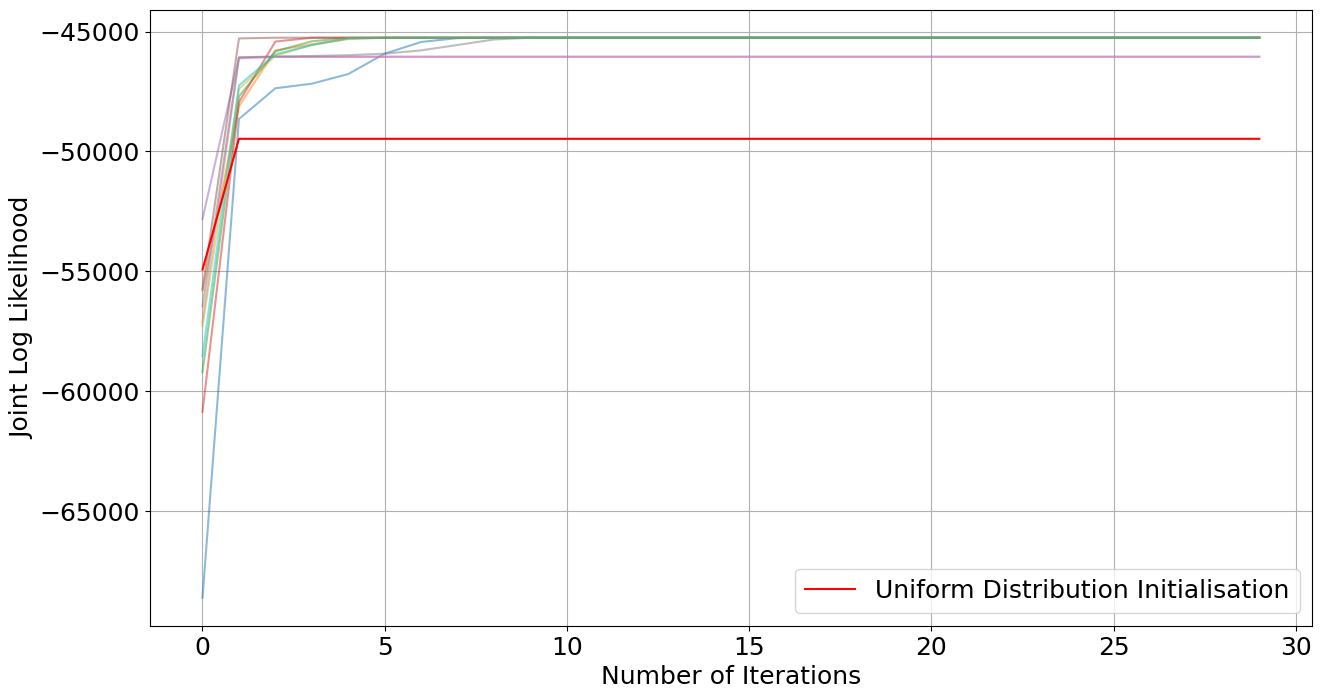

In [35]:
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 18})
for ll in all_loglik_iter:
    plt.plot(np.array(ll), alpha=0.5)
m_log_lik = np.array(all_loglik_iter).mean(axis=0)
v_log_lik = np.array(all_loglik_iter).std(axis=0)
#plt.fill_between(np.arange(len(m_log_lik)), m_log_lik-0.5*v_log_lik, m_log_lik+0.5*v_log_lik, alpha = 0.4)
plt.plot(loglik_iter_u, color = 'r', label = 'Uniform Distribution Initialisation')
plt.xlabel('Number of Iterations')
plt.ylabel('Joint Log Likelihood')
plt.grid()
plt.legend()
plt.savefig('llgraph.png')
plt.show()

# All the parameters from mixture of markov chains based on unifrom initialisation of parameters 

In [36]:
print(pi_u, A_u, B_u)

[[0.33333333]
 [0.33333333]
 [0.33333333]] [[0.374 0.374 0.374]
 [0.404 0.404 0.404]
 [0.222 0.222 0.222]] [[[0.15977377 0.15977377 0.15977377]
  [0.14452926 0.14452926 0.14452926]
  [0.48703845 0.48703845 0.48703845]]

 [[0.30597384 0.30597384 0.30597384]
  [0.28346056 0.28346056 0.28346056]
  [0.35019099 0.35019099 0.35019099]]

 [[0.53425239 0.53425239 0.53425239]
  [0.57201018 0.57201018 0.57201018]
  [0.16277056 0.16277056 0.16277056]]]


In [37]:
print(pi_u.round(4))
print('........')
print(A_u.round(4))
print('........')
print(B_u.round(4))

[[0.3333]
 [0.3333]
 [0.3333]]
........
[[0.374 0.374 0.374]
 [0.404 0.404 0.404]
 [0.222 0.222 0.222]]
........
[[[0.1598 0.1598 0.1598]
  [0.1445 0.1445 0.1445]
  [0.487  0.487  0.487 ]]

 [[0.306  0.306  0.306 ]
  [0.2835 0.2835 0.2835]
  [0.3502 0.3502 0.3502]]

 [[0.5343 0.5343 0.5343]
  [0.572  0.572  0.572 ]
  [0.1628 0.1628 0.1628]]]


# All the parameters from mixture of markov chains based on random initialisation of parameters

In [38]:
print(pi, A, B)

[[0.29969894]
 [0.192     ]
 [0.50830106]] [[1.92146713e-01 4.27083333e-01 4.61171247e-01]
 [4.19251244e-01 5.72916667e-01 3.31203021e-01]
 [3.88602044e-01 1.21265181e-36 2.07625732e-01]] [[[0.05971003 0.38869863 0.07051106]
  [0.13007012 0.2405914  0.13676591]
  [0.41759899 0.54531568 0.5107758 ]]

 [[0.13950709 0.14848337 0.49465443]
  [0.32378127 0.51545699 0.22585642]
  [0.42784294 0.01756619 0.43723563]]

 [[0.80078288 0.462818   0.43483451]
  [0.54614861 0.24395161 0.63737768]
  [0.15455807 0.43711813 0.05198857]]]


In [39]:
print(pi.round(4))
print('........')
print(A.round(4))
print('........')
print(B.round(4))

[[0.2997]
 [0.192 ]
 [0.5083]]
........
[[0.1921 0.4271 0.4612]
 [0.4193 0.5729 0.3312]
 [0.3886 0.     0.2076]]
........
[[[0.0597 0.3887 0.0705]
  [0.1301 0.2406 0.1368]
  [0.4176 0.5453 0.5108]]

 [[0.1395 0.1485 0.4947]
  [0.3238 0.5155 0.2259]
  [0.4278 0.0176 0.4372]]

 [[0.8008 0.4628 0.4348]
  [0.5461 0.244  0.6374]
  [0.1546 0.4371 0.052 ]]]


# Log Likelihood of first 10 obervation based on random initalisation and learnt parameters

In [40]:
loglik_ran = loglik_out(v,A,pi,B)

In [41]:
print('The log liklihood of the of the given data for calculated parameters is :',round(loglik_ran['Log Likelihood'].sum(),4))

The log liklihood of the of the given data for calculated parameters is : -45254.5104


# Log Likelihood of first 10 obervation based on unifrom initalisation and learnt parameters

In [42]:
loglik_u= loglik_out(v,A_u,pi_u,B_u)

print('The log liklihood of the of the given data for calculated parameters based on unifrom initialisation is :',round(loglik_u['Log Likelihood'].sum(),4))

The log liklihood of the of the given data for calculated parameters based on unifrom initialisation is : -49473.5473


In [43]:
a,b,c,d = log_posterior(v,A,pi,B)


# Log Posterior , Log Posterior and Most Probable hidden state

In [44]:
df1 = pd.DataFrame(list(map(np.ravel, a[:10])))
df2 = pd.DataFrame(list(map(np.ravel, b[:10])))
df3 = pd.DataFrame(list(map(np.ravel, c[:10])))

In [45]:
df_fin = pd.concat([df1, df2,df3],axis=1)

In [46]:
df_fin

,0,1,2,0,1,2,0
0,-5.0547e+01,0.0000e+00,-6.8274e+01,1.1164e-22,1.0000e+00,2.2325e-30,1
1,-1.9073e-04,-8.2011e+01,-8.5647e+00,9.9981e-01,2.4170e-36,1.9072e-04,0
2,-1.2574e+01,-1.0404e+02,-3.4614e-06,3.4614e-06,6.5542e-46,1.0000e+00,2
3,-1.9754e+01,-5.9341e+01,-2.6350e-09,2.6350e-09,1.6924e-26,1.0000e+00,2
4,-1.2043e+01,-6.8305e+01,-5.8865e-06,5.8865e-06,2.1644e-30,9.9999e-01,2
5,-3.7588e-05,-7.2571e+01,-1.0189e+01,9.9996e-01,3.0407e-32,3.7587e-05,0
6,-4.2705e+01,0.0000e+00,-6.3361e+01,2.8410e-19,1.0000e+00,3.0386e-28,1
7,-1.8721e+01,-8.0554e+01,-7.4048e-09,7.4048e-09,1.0376e-35,1.0000e+00,2
8,-1.2664e+01,-1.6169e+02,-3.1637e-06,3.1637e-06,6.0215e-71,1.0000e+00,2
9,-1.3023e+01,-8.4823e+01,-2.2099e-06,2.2099e-06,1.4514e-37,1.0000e+00,2


In [47]:
pd.set_option('display.float_format', lambda x: '{:.4e}'.format(x))
df_fin

,0,1,2,0,1,2,0
0,-5.0547e+01,0.0000e+00,-6.8274e+01,1.1164e-22,1.0000e+00,2.2325e-30,1
1,-1.9073e-04,-8.2011e+01,-8.5647e+00,9.9981e-01,2.4170e-36,1.9072e-04,0
2,-1.2574e+01,-1.0404e+02,-3.4614e-06,3.4614e-06,6.5542e-46,1.0000e+00,2
3,-1.9754e+01,-5.9341e+01,-2.6350e-09,2.6350e-09,1.6924e-26,1.0000e+00,2
4,-1.2043e+01,-6.8305e+01,-5.8865e-06,5.8865e-06,2.1644e-30,9.9999e-01,2
5,-3.7588e-05,-7.2571e+01,-1.0189e+01,9.9996e-01,3.0407e-32,3.7587e-05,0
6,-4.2705e+01,0.0000e+00,-6.3361e+01,2.8410e-19,1.0000e+00,3.0386e-28,1
7,-1.8721e+01,-8.0554e+01,-7.4048e-09,7.4048e-09,1.0376e-35,1.0000e+00,2
8,-1.2664e+01,-1.6169e+02,-3.1637e-06,3.1637e-06,6.0215e-71,1.0000e+00,2
9,-1.3023e+01,-8.4823e+01,-2.2099e-06,2.2099e-06,1.4514e-37,1.0000e+00,2


In [48]:
df_fin.to_csv('distribution_final.csv')